# Train and Serve a watsonx.ai Custom Model

## Part 1: Train a classification model for MSDS in IBM Watson Studio

This two-part mini-series demonstrates a use-case, in which you train a model in [IBM Watson Studio](https://www.ibm.com/products/watson-studio) with data from [SAP Datasphere](https://help.sap.com/docs/SAP_DATASPHERE) and deploy it to [SAP AI Core](https://help.sap.com/docs/sap-ai-core). You could independently run the two notebooks provided without major modifications, if you only want to train or serve a similar model.

You will learn:

- How to access datasets stored in SAP Datasphere
- How to train a model in Watson Studio
- How to sync a trained model to SAP AI Core
- How to create a workflow to serve a model
- How to deploy a model and use it for online inferencing

### Prerequisites

- [SAP Businness Technology Platform (BTP)](https://help.sap.com/docs/btp) services and applications
    - [SAP Datasphere](https://discovery-center.cloud.sap/serviceCatalog/sap-datasphere?region=all)
    - [SAP AI Core](https://discovery-center.cloud.sap/serviceCatalog/sap-ai-core?region=all)
    - [SAP AI Launchpad](https://discovery-center.cloud.sap/serviceCatalog/sap-ai-launchpad?region=all)
    - [Object Store](https://help.sap.com/docs/object-store)
- Access to a [project](https://www.ibm.com/docs/en/watsonx?topic=projects) in watsonx
- Your entitlement key from the [container software library](https://myibm.ibm.com/products-services/containerlibrary) to access the IBM Entitled Registry
- A [GitHub repository](https://docs.github.com/en/get-started/quickstart/create-a-repo) and [personal access token (PAT)](https://docs.github.com/en/authentication/keeping-your-account-and-data-secure/managing-your-personal-access-tokens) to access the repository

## Table of Contents

1.  [Step 1: Load data from SAP Datasphere](#load_data)

1.  [Step 2: Data Processing](#data_procesing)

1.  [Step 3: Train a TF-IDF SVM classification model with Watson NLP](#train_model)

1.  [Step 4: Model Evaluation](#model_evaluation)

1.  [Step 5: Creating and plotting a confusion matrix](#confusion_matrix)

1.  [Step 6: Save the classification model](#save_model)

1.  [Summary](#summary)

<div class="alert alert-block alert-danger">
<b>Stop kernel of other notebooks.</b></div>

**Note:** If you have other notebooks currently running with NLP Runtime 23.1 on Python 3.10 XS environment, **stop their kernels** before running this notebook. All these notebooks share the same runtime environment, and if they are running in parallel, you may encounter memory issues. To stop the kernel of another notebook, open that notebook, and select _File > Stop Kernel_.

<div class="alert alert-block alert-warning">
<b>Set Project token.</b></div>

Before you can begin working on this notebook in Watson Studio in Cloud Pak for Data as a Service, you need to ensure that the project token is set so that you can access the project assets via the notebook.

When this notebook is added to the project, a project access token should be inserted at the top of the notebook in a code cell. If you do not see the cell above, add the token to the notebook by clicking **More > Insert project token** from the notebook action bar.  By running the inserted hidden code cell, a project object is created that you can use to access project resources.

![ws-project.mov](https://media.giphy.com/media/jSVxX2spqwWF9unYrs/giphy.gif)
<div class="alert alert-block alert-info">
<b>Tip:</b> Cell execution</div>

Note that you can step through the notebook execution cell by cell, by selecting Shift-Enter. Or you can execute the entire notebook by selecting **Cell -> Run All** from the menu.

In [1]:
# The code was removed by Watson Studio for sharing.

<div class="alert alert-block alert-warning">
<b>Set some secrets and variables.</b></div>

Before you begin in part 1, you'll need to use your own credentials to replace what's in the examples below. To avoid sharing them accidentally, copy the following code block into a new code cell, and make it a hidden cell by adding `# @hidden_cell` to the top.

```
# @hidden_cell
# SAP Datasphere OAuth2 Client credential
dsp_client_id = '<your_client_id>'
dsp_client_secret = '<your_client_secret>'
dsp_token_url = '<token_url_of_your_datasphere_instance>'
dsp_refresh_token = '<refresh_token_from_your_datasphere_login_session>'

# Dataset for model training
dataset_name = '<name_of_dataset>'
dataset_base_url = '<base_url_of_your_dataset_in_datasphere>'
```

**Note:** You need to [log into the SAP Datasphere Command Line Interface via an OAuth Client](https://help.sap.com/docs/SAP_DATASPHERE/d0ecd6f297ac40249072a44df0549c1a/eb7228a171a842fa84e48c899d48c970.html), and run the following command to get a `refresh token`.

```
datasphere config secrets show
```

In [2]:
# The code was removed by Watson Studio for sharing.

<a id="load_data"></a>
### Step 1: Load data from SAP Datasphere

The data used in this notebook is taken from this Kaggle dataset: https://www.kaggle.com/datasets/eliseu10/material-safety-data-sheets. The original MSDS dataset contains Material Safety Data Sheet files in the .txt format. The data was collected from hazard.com. The dataset contains 2 types of files with different structure: 1) f1 type, with 17,454 files (155.4MB); and 2) f2 type, with 236,507 files (1.3GB).

The dataset has been prepared and downsampled to quickly train classification models.

In [3]:
# Import some Python modules
import requests
import json
import pandas as pd

In [4]:
# Generate an access token for making subsequent REST API calls
auth = (dsp_client_id, dsp_client_secret)

params = {
  "grant_type": "refresh_token",
  "refresh_token": dsp_refresh_token
}

url = dsp_token_url

response = requests.post(url, auth=auth, data=params)
access_token = response.json()['access_token']

In [5]:
# Make a REST call to download data and store the data in a JSON object
headers = {'Authorization': 'Bearer ' + access_token}
response = requests.get(dataset_base_url + "/" + dataset_name, headers=headers, verify=True)
msds_json = json.loads(json.dumps(response.json()['value'], indent=4))

# Retrieve the rest of the dataset, when it exceeds the response size limit
while "@odata.nextLink" in response.json():
    response = requests.get(dataset_base_url + "/" + response.json()['@odata.nextLink'], headers=headers, verify=True)
    more_msds_json = json.loads(json.dumps(response.json()['value'], indent=4))
    msds_json.extend(more_msds_json)

print('Total number of MSDS in dataset:', len(msds_json))

Total number of MSDS in dataset: 3088


In [6]:
# We want to show large text snippets to be able to explore the relevant text
pd.options.display.max_colwidth = 5000

# Shuffle the data and store in dataframe
msds_df = pd.DataFrame.from_dict(msds_json).sample(frac = 1)

# Preview the data set
msds_df.head(5)

,file_name,effects_overexposure_chronic,effects_overexposure_eyes,effects_overexposure_ingestion,effects_overexposure_inhalation,effects_overexposure_skin,first_aids_chronic,first_aids_eyes,first_aids_ingestion,first_aids_inhalation,...,other_precautions,protective_equipment,protective_gloves,respiratory_protection,ventilation,disposal,extinguishing_media,fire_fighting,handling_storage,spill
437,blmwc,,eyes & respiratory tract.,,,,,eyes:hold eyelid open & flush with water for 15 minutes.skin:wipe excess with a dry cloth.then wash with plenty of water & soap.inhalation :remove to fresh air.give cpr/oxygen ifneeded.ingestion:get medical attention at once.,ingestion:get medical attention at once.,inhalation :remove to fresh air.give cpr/oxygen ifneeded.ingestion:get medical attention at once.,...,"KEEP IN AN AREA WITH AN ACID RESISTANT CEMENT FLOOR. DO NOT BREATHE SPRAYS OR MISTS. DO NOT INGEST. DO NOT GET IN EYES, ON SKIN OR ON CLOTHING. KEEP OUT OR THE REACH OF CHILDREN. DO NOT COMBINE WITH A LKALINE DRAIN CLEANERS.","MAINTAIN A SINK,SAFETY SHOWER,EYEWASH FOUNTAIN IN WORK AREA.HAVE OXYGEN READILY AVAILABLE.FULL-BODY PROTECTIVE CLOTHING.",RUBBER OR PVC,"USE NIOSH/MSHA APPROVED MIST FILTER, ACID GAS CARTRIDGE RESPIRATOR. USE POSITIVE PRESSURE SELF-CONTAINED BREATHING APPARATUS FOR EMERGENCY CONDITIONS WHERE EXPOSURE LIMITS ARE EXCEEDED.",LOCAL EXHAUST,"DISPOSE OF IN ACCORDANCE WITH ALL APPLICABLE LOCAL, STATE AND FEDERAL REGULATIONS.THIS MATERIAL IS RCRA HAZARDOUS WASTE D002,CORROSIVE & D003,REACTIVE.SPILLS ARE SUBJECT TO CERLCA REPORTING REQUIREMEN TS:RQ=1000 LBS.",EXPECT VIOLENT REACTION WITH WATER. USE DRY CHEMICAL OR CARBON DIOXIDE.,WEAR FIRE FIGHTING PROTECTIVE EQUIPMENT AND A FULL FACED SELF CONTAINED BREATHING APPARATUS.FIGHT FIRE FROM A SAFE DISTANCE.USE ACID RESISTANT EQUIPMENTS.,"STORAGE-STORE IN COOL,DRY PLACE.AVOID EXCESSIVE HEAT & BELOW FREEZING TEMPERATURES.","WEAR PROTECTIVE EQUIPMENT.STOP LEAK IF POSSIBLE.SMALL SPILLS SHOULD BE COVERED WITH NA BICARBONATE,SODA ASH,OR LIME.AVOID FOAMING/SPATTERING.PICK UP WITH ABSORBING MATERIAL & TRANSFER TO A SUITABLE CH EMICAL WASTE CONTAINER.DON'T WASH IT DOWN TO SEWER"
2072,cjqsl,,,,,,,flush with water for at least 15 minutes.,,,...,AVOID PROLONGED INHALATION OF EXCESSIVE DUST.,"ANSI APPRVD EYE WASH & DELUGE SHOWER . FOR USE OTHER THAN NORMAL CUSTOMER-OPERATING PROC (SUCH AS IN BULK TONER PROCESSING FACILITIES), GOGGLES & RESP MAY BE REQUIRED. FOR INFO, CONTACT XEROX.",NONE REQUIRED WHEN USE AS INTENDED. IMPERVIOUS GLOVES .,NONE REQUIRED WHEN USED AS INTENDED. NIOSH APPROVED RESPIRATOR APPROPRIATE FOR EXPOSURE OF CONERN .,,"THIS MATERIAL IS NOT A HAZARDOUS WASTE ACCORDING TO FEDERAL REGULATION 40 CFR 261 WHEN DISPOSED. STATE AND LOCAL REQUIREMENTS, HOWEVER MAY BE MORE RESTRICTIVE. CONSULT WITH THE APPROPRIATE STATE AND L OCAL WASTE DISPOSAL AUTHORITIES FOR ADDITIONAL INFORMATION.","WATER, FOAM, DRY CHEMICAL.",USE NIOSH APPROVED SCBA & FULL PROTECTIVE EQUIPMENT . AVOID INHALATION OF SMOKE.,NONE.,"IF SPILLED, SWEEP UP OR VACUUM."
779,bkyky,,,,,,,,,,...,,,,,,LANDFILL IS PREFERRED METHOD.,"WATER, ALCOHOL FOAM, CHEMICAL POWDER, CO2",SELF-CONTAINED BREATHING APPARATUS.,"NO SPECIAL PRECAUTION IS NECESSARY. STORE IN A COOL, DRY AREA.",
2622,bwryh,"liver, kidney, ns.",,,,,,,,,...,CONTAINERS OF THIS MATERIAL MAY BE HAZARDOUS WHEN EMPTY. DO NOT WELD OR FLAME CUT ON EMPTY DRUMS. SHOCK FROM DROPPING MAY SPLIT CONTAINER. CONTACT LENSES SHOULD NOT BE WORN WHEN WORKING WITH THIS MATE RIAL.,EMPLOYEES SHOULD WASH PROMPTLY WHEN SKIN BECOMES CONTAMINATED. REMOVE CLOTHING THAT BECOMES WET (TO AVOID FLAMMABILITY).,CHEM RESISTANT (NITRILE/VITON) GLOVES,WEAR APPROPRIATE (TYPE TC-23C-75) PROPERLY FITTED HALF-MASK OR FULL FACEPIECE RESPIRATOR (NIOSH/MSHA) DURING & AFTER APPLICATION UNLESS AIR MONITORING DEMONSTRATES VAPOR/MIST LEVELS BELOW APPLICABLE L IMITS. FOLLOW RESPRTR MFR USE DIRECTIONS,KEEP AIR CONCEN BELOW PEL/TLV.REMOVE DECOMP FORMED DURING WELD/FLAME CUT COATED SURFACES.VENT VAPOR FROM BAKING

<a id="data_procesing"></a>
### Step 2: Data processing

Many classification algorithms work best if the training samples are equally split across the classes. If the data is unbalanced, algorithms might decide to favor classes with many samples to achieve an overall good result. To avoid this, you will sample the data in the next step to filter out instances with fewer classes.

To avoid long runtimes in this sample notebook, you will use only a small number of samples. However, this can reduce the quality of the classification models. In a real-case scenario, you should increase the number of samples per product group to get better results.

In [7]:
# Combining all the text columns into a single column for simplicity
msds_df['text'] = msds_df[
    [
        "effects_overexposure_chronic", "effects_overexposure_eyes", "effects_overexposure_ingestion",
        "effects_overexposure_inhalation", "effects_overexposure_skin", "first_aids_chronic", "first_aids_eyes",
        "first_aids_ingestion", "first_aids_inhalation", "first_aids_skin", "health_hazards_chronic", "health_hazards_eyes",
        "health_hazards_ingestion", "health_hazards_inhalation", "health_hazards_skin", "appearance", "conditions_avoid",
        "decomposition_products", "eyes_protection", "other_precautions", "protective_equipment", "protective_gloves",
        "respiratory_protection", "ventilation"
    ]
].apply(lambda x: ' '.join(x.dropna()), axis=1)

In [8]:
# pd.set_option("display.max_rows", None)

msds_df['fire_fighting'].value_counts().head(10)

                                                                                                                                                                    358
FIRE FIGHTERS SHOULD USE NIOSH APPROVED SCBA & FULL PROTECTIVE EQUIPMENT WHEN FIGHTING CHEMICAL FIRE. USE WATER SPRAY TO COOL NEARBY CONTAINERS EXPOSED TO FIRE.    190
COMBUSTION PRODUCTS OF THIS MATERIAL MAY BE TOXIC. USE A SELF-CONTAINED BREATHING APPARATUS WHEN FIGHTING FIRES INVOLVING CHEMICAL PRODUCTS.                        152
USE NIOSH APPROVED SCBA AND FULL PROTECTIVE EQUIPMENT .                                                                                                              76
SELF-CONTAINED BREATHING APPARATUS.                                                                                                                                  66
WEAR CHEMICAL PROTECTIVE SUIT WITH SELF CONTD BRTHG APP.                                                                                                        

In [9]:
# Identify the top 10 most frequent categories in the 'fire_fighting' column
top_10_categories = msds_df['fire_fighting'].value_counts().head(10).index

# Filter the dataframe to retain rows belonging to these top 10 categories
filtered_msds_df = msds_df[msds_df['fire_fighting'].isin(top_10_categories)]

filtered_msds_df = filtered_msds_df[filtered_msds_df['fire_fighting'] != '']
filtered_msds_df['fire_fighting'].value_counts()

FIRE FIGHTERS SHOULD USE NIOSH APPROVED SCBA & FULL PROTECTIVE EQUIPMENT WHEN FIGHTING CHEMICAL FIRE. USE WATER SPRAY TO COOL NEARBY CONTAINERS EXPOSED TO FIRE.    190
COMBUSTION PRODUCTS OF THIS MATERIAL MAY BE TOXIC. USE A SELF-CONTAINED BREATHING APPARATUS WHEN FIGHTING FIRES INVOLVING CHEMICAL PRODUCTS.                        152
USE NIOSH APPROVED SCBA AND FULL PROTECTIVE EQUIPMENT .                                                                                                              76
SELF-CONTAINED BREATHING APPARATUS.                                                                                                                                  66
WEAR CHEMICAL PROTECTIVE SUIT WITH SELF CONTD BRTHG APP.                                                                                                             63
NONE                                                                                                                                                            

In the next step, you will split the data into training and test data (ratio:80/20).

In [10]:
from sklearn.model_selection import train_test_split

# Splitting the filtered dataset into training and testing sets (80% train, 20% test)
train_df, test_df = train_test_split(filtered_msds_df, test_size=0.2, random_state=42, stratify=filtered_msds_df['fire_fighting'])

train_df.shape, test_df.shape

((608, 31), (153, 31))

You have created two dataframes, one for the training and one for the test data. The data is still in its original format. Now you need to bring the data into a format that is usable by the Watson NLP classification algorithms. This can be either `JSON` or `CSV` format.

In the sample, you will create the data in `JSON` format. The training and test data is written to files.

In [11]:
def prepare_data(df):
    # only the text column and the target label *Product* are needed
    df_out = df[['text', 'fire_fighting']].reset_index(drop=True)
    # rename to the identifiers expected by Watson NLP
    df_out = df_out.rename(columns={"text": "text", 'fire_fighting': 'labels'})
    # the label column should be an array (although we have only one label per complaint)
    df_out['labels'] = df_out['labels'].map(lambda label: [label,])
    return df_out
    
train_df = prepare_data(train_df)
train_file = './train_data.json'
train_df.to_json(train_file, orient='records')
    
test_df = prepare_data(test_df)
test_file = './test_data.json'
test_df.to_json(test_file, orient='records')

train_df.head(2)

,text,labels
0,"eye: potential irritation from airborne dust; ingest: n/k. inhalation of airborne dust containing asbestos fibers on repeated exposure may cause or can lead to asbestosis / mesothelioma; skin: n/k; eye: potential irritation from airborne dust; ingest: n/k. skin: n/k; eye: potential irritation from airborne dust; ingest: n/k. chronic: dust from abrasive actions(eg. MANUFACTURED COMMODITY DESCRIBED BY LOGISTICS: ""ITEM-NAME"" NONE KNOWN SAFETY GLASSES W/SIDE SHIELDS OR GOGGLES AS MANUFACTURED, LOCKED-IN ASBESTOS DOES NOT PRESENT A HAZARD. ONLY WHEN THE ITEM IS SUBJECTED TO ABRASIVE ACTIONS & DUST IS GENERATED, THEN ASBESTOS FIBERS MAY BE RELEASED & BECOME AIRBORNE. AS REQUIRED FOR TASK AT HAND, AND THE GUIDANCE SET FORTH BY YOUR SAFETY OFFICE OR IH PERSONNEL AS REQUIRED FOR TASK AT HAND. IF EXPOSURES EXCEED ESTABLISHED LIMITS, A NIOSH/MSHA APPROVED RESPIRATOR FOR ASBESTOS SHOULD BE USED. CONSULT YOUR SAFETY OFFICE/IH PERSONNEL FOR GUIDANCE FOR THE TASK AT HAND. LOCAL EXHAUST IS RECOMMENDED IN SITUATIONS WHERE DUST IS GENERATED BY ABRASIVE ACTIONS, ABRASION OR OTHER MEANS.",[COMBUSTION PRODUCTS OF THIS MATERIAL MAY BE TOXIC. USE A SELF-CONTAINED BREATHING APPARATUS WHEN FIGHTING FIRES INVOLVING CHEMICAL PRODUCTS.]
1,"eye: potential irritation from airborne dust; ingest: n/k. inhalation of airborne dust containing asbestos fibers on repeated exposure may cause or can lead to asbestosis / mesothelioma; skin: n/k; eye: potential irritation from airborne dust; ingest: n/k. skin: n/k; eye: potential irritation from airborne dust; ingest: n/k. chronic: dust from abrasive actions(eg. MANUFACTURED COMMODITY DESCRIBED BY LOGISTICS: ""ITEM-NAME"" NONE KNOWN SAFETY GLASSES W/SIDE SHIELDS OR GOGGLES AS MANUFACTURED, LOCKED-IN ASBESTOS DOES NOT PRESENT A HAZARD. ONLY WHEN THE ITEM IS SUBJECTED TO ABRASIVE ACTIONS & DUST IS GENERATED, THEN ASBESTOS FIBERS MAY BE RELEASED & BECOME AIRBORNE. AS REQUIRED FOR TASK AT HAND, AND THE GUIDANCE SET FORTH BY YOUR SAFETY OFFICE OR IH PERSONNEL AS REQUIRED FOR TASK AT HAND. IF EXPOSURES EXCEED ESTABLISHED LIMITS, A NIOSH/MSHA APPROVED RESPIRATOR FOR ASBESTOS SHOULD BE USED. CONSULT YOUR SAFETY OFFICE/IH PERSONNEL FOR GUIDANCE FOR THE TASK AT HAND. LOCAL EXHAUST IS RECOMMENDED IN SITUATIONS WHERE DUST IS GENERATED BY ABRASIVE ACTIONS, ABRASION OR OTHER MEANS.",[COMBUSTION PRODUCTS OF THIS MATERIAL MAY BE TOXIC. USE A SELF-CONTAINED BREATHING APPARATUS WHEN FIGHTING FIRES INVOLVING CHEMICAL PRODUCTS.]


<a id="train_model"></a>
### Step 3: Train a TF-IDF SVM classification model with Watson NLP

SVM is an established classification approach. Watson NLP includes an SVM algorithm that exploits the `SnapML` libraries for faster training. The algorithm utilizes either `TF-IDF` or `USE` embeddings. The `TF-IDF` SVM classifier workflow depends on the syntax block. So, start by loading the syntax model.

In [12]:
import watson_nlp

# Syntax Model
syntax_model = watson_nlp.load('syntax_izumo_en_stock')

use_embedding_model = watson_nlp.load('embedding_use_en_stock')

In [13]:
from watson_core.data_model.streams.resolver import DataStreamResolver
from watson_core.data_model.streams.resolver import DataStreamResolver
from watson_core.toolkit import fileio
from watson_nlp.workflows.classification.base_classifier.tfidf_svm import TFidfSvm
from watson_nlp.workflows.classification.base_classifier.use_svm import UseSvm
from watson_nlp.workflows.classification.generic_ensemble import GenericEnsemble
from watson_nlp.workflows.classification.base_classifier import GloveCNN
from watson_core.toolkit.quality_evaluation import QualityEvaluator, EvalTypes

Classification blocks expect the training data in data streams. You can create data streams using several utility methods, as shown below:

In [14]:
training_data_file = train_file

# Create datastream from training data
data_stream_resolver = DataStreamResolver(target_stream_type=list, expected_keys={'text': str, 'labels': list})
training_data = data_stream_resolver.as_data_stream(training_data_file)

# Create Syntax stream
text_stream, labels_stream = training_data[0], training_data[1]
syntax_stream = syntax_model.stream(text_stream)

use_train_stream = use_embedding_model.stream(syntax_stream, doc_embed_style='raw_text')
use_svm_train_stream = watson_nlp.data_model.DataStream.zip(use_train_stream, labels_stream)

Train the classifier:

In [15]:
# Train the TF-IDF SVM model
tfidf_classification_model = TFidfSvm.train(training_data=training_data,
                       syntax_model=syntax_model, 
                       tfidf_svm_epochs=10,
                       multi_label=True
                      )

<a id="model_evaluation"></a>
### Step 4: Model Evaluation

Now you are able to run the trained models on new data. You will run the models on the test data so that the results can also be used for model evaluation. For illustration purposes, the data is used in the original format that you started out with because the format of the new MSDS that you receive might also be in that format.

Create a helper method to run both models on MSDS and return the predicted Fire fighting technique:

In [16]:
def predict_product(text,tfidf_classification_model):
    tfidf_svm_preds = tfidf_classification_model.run(text)
    predicted_tfidf_svm = tfidf_svm_preds.to_dict()["classes"][0]["class_name"]
    return predicted_tfidf_svm

Run the model on the complete test data:

In [17]:
def model_evalution(test_df,text_col,tfidf_classification_model):
    predictions = test_df[text_col].apply(lambda text: predict_product(text,tfidf_classification_model))
    print(type(predictions))
    frame ={'Predicted SVM':predictions}
    predictions_df = pd.DataFrame(frame)
                                                       
    result_df = test_df[[text_col, "labels"]].merge(predictions_df, how='left', left_index=True, right_index=True)
    return result_df

In [18]:
result_df = model_evalution(test_df,'text',tfidf_classification_model)
result_df['labels'] = result_df['labels'].str[0]

result_df.head()

<class 'pandas.core.series.Series'>


,text,labels,Predicted SVM
0,"DEPENDS ON CHEMICAL COMPOSITION; FISSION PRODUCTS SAFETY GLASSES EYE WASH STATION. APRONS. SPECIAL IMPERVIOUS CLOTHING. IMPERVIOUS SCBA IF INVOLVED IN FIRE, OTHERWISE GAS MASK. PROVIDE MECHAN(GEN/LOCAL EXHAUST)VENT TO MAINTN <TLV",WEAR CHEMICAL PROTECTIVE SUIT WITH SELF CONTD BRTHG APP.,WEAR CHEMICAL PROTECTIVE SUIT WITH SELF CONTD BRTHG APP.
1,"remove to fresh air. eye & skin irritation. skin irritation. VARIOUS COLORS, HONEY LIKE SUBSTANCE-CHARACTERISTIC ODOR HIGH TEMPERATURES, SPARKS, AND OPEN FLAMES CO AND/OR C0*2 USE CHEMICAL SAFETY GOGGLES. READ AND FOLLOW DIRECTIONS ON LABEL. DO NOT REUSE CONTAINERS. APRON AND WORK CLOTHING TO MINIMIZE EXPOSURE. EYE WASH STATION & SAFETY SHOWER RECOMMENDED. NEOPRENE, PVA GLOVES RECOMMENDED. IN HIGH VAPOR AREA, USE NIOSH/MSHA APPROVED RESPIRATOR WITH ORGANIC VAPOR CARTRIDGE. USE SELF-CONTAINED BREATHING APPARATUS IF VAPOR LEVELS EXCEED 1000 PPM. GEMERAL OR LOCAL EXHAUST RECOMMENDED TO CONTROL VAPORS BELOW 50% OF TLV.",FIRE FIGHTERS SHOULD USE NIOSH APPROVED SCBA & FULL PROTECTIVE EQUIPMENT WHEN FIGHTING CHEMICAL FIRE. USE WATER SPRAY TO COOL NEARBY CONTAINERS EXPOSED TO FIRE.,FIRE FIGHTERS SHOULD USE NIOSH APPROVED SCBA & FULL PROTECTIVE EQUIPMENT WHEN FIGHTING CHEMICAL FIRE. USE WATER SPRAY TO COOL NEARBY CONTAINERS EXPOSED TO FIRE.
2,"flush with water for at least 15 minutes. CLEAR, PALE GREEN-BLUE SOLUTION WITH NO ODOR. EXCESSIVE HEAT OR COLD. OXIDES OF NITROGEN. ANSI APPVD CHEM WORKERS GOGG (SUP DAT). NONE. LAB COAT OR APRON. EMERGENCY EYEWASH AND DELUGE SHOWER MEETING ANSI DESIGN CRITERIA . NEOPRENE GLOVES. WEAR NIOSH/MSHA APPROVED RESPIRATOR APPROPRIATE FOR EXPOSURE OF CONCERN . LOCAL EXHAUST.",WEAR NIOSH/MSHA APPROVED SCBA AND FULL PROTECTIVE EQUIPMENT .,USE NIOSH APPROVED SCBA AND FULL PROTECTIVE EQUIPMENT .
3,"LIGHT AMBER, SLIGHT ODOR NONE NONE LOCAL EXHAUST RECOMMENDED",NONE,NONE
4,"eyes and skin:flush with large amount of water for about 15-20 minutes;seek medical attention immediately.inhalation:remove to fresh air;call a physician.ingestion:seek medical attention immediately. ingestion:seek medical attention immediately. inhalation:remove to fresh air;call a physician.ingestion:seek medical attention immediately. skin:flush with large amount of water for about 15-20 minutes;seek medical attention immediately.inhalation:remove to fresh air;call a physician.ingestion:seek medical attention immediately. eyes;ingestion may cause stomach distress,nausea or vomiting. ingestion may cause stomach distress,nausea or vomiting. WHITE POWDER;LAVENDER ODOR. DO NOT MIX WITH ANYTHING BUT WATER NOT SPECIFIED SAFETY GLASSES WASH THOROUGHLY AFTER EACH USE. EYE-WASH FACILITIES,HAND CREAM OR LOTION. AS REQUIRED NORMALLY NOT NEEDED. GENERAL TO MAINTAIN PEL/TLV.",FIRE FIGHTERS SHOULD USE NIOSH APPROVED SCBA & FULL PROTECTIVE EQUIPMENT WHEN FIGHTING CHEMICAL FIRE. USE WATER SPRAY TO COOL NEARBY CONTAINERS EXPOSED TO FIRE.,FIRE FIGHTERS SHOULD USE NIOSH APPROVED SCBA & FULL PROTECTIVE EQUIPMENT WHEN FIGHTING CHEMICAL FIRE. USE WATER SPRAY TO COOL NEARBY CONTAINERS EXPOSED TO FIRE.


<a id="confusion_matrix"></a>
### Step 5: Creating and plotting a confusion matrix

Now you can evaluate the accuracy of the classification model by creating confusion matrix. You can use [sklearn's classification report](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html) to build a text report showing the main classification metrics, use the pandas `crosstab` to create a confusion matrix for both the SVM and the ensemble model, and plot them as `Seaborn` heatmaps.

Creating a helper function `confusion_matrix` to create confusion matrix:

In [19]:
# confusion matrix in sklearn
from sklearn.metrics import classification_report
def confusion_matrix(result_df):
    # actual values
    actual = result_df['labels']
    # predicted values
    predicted_svm = result_df['Predicted SVM']

    # classification report for precision, recall f1-score and accuracy
    matrix = classification_report(actual,predicted_svm)
    print('Classification report for SVM classifier: \n',matrix)

Creating a helper function `create_plot` to visualize confusion matrix:

In [20]:
import seaborn as sn
import matplotlib.pyplot as plt

def create_plot(result_df):
    SVM_confusion_df = pd.crosstab(result_df['labels'], result_df['Predicted SVM'], rownames=['Actual'], normalize='index')

    figure, (ax1) = plt.subplots(ncols=1, figsize=(15,7))
    sn.heatmap(SVM_confusion_df, annot=True, cmap="YlGnBu", ax=ax1, cbar=False)
    ax1.title.set_text("SVM")
    plt.show()

Create `confusion_matrix` on the entire test dataset:

In [21]:
confusion_matrix(result_df)

Classification report for SVM classifier: 
                                                                                                                                                                   precision    recall  f1-score   support

                    COMBUSTION PRODUCTS OF THIS MATERIAL MAY BE TOXIC. USE A SELF-CONTAINED BREATHING APPARATUS WHEN FIGHTING FIRES INVOLVING CHEMICAL PRODUCTS.       1.00      1.00      1.00        31
FIRE FIGHTERS SHOULD USE NIOSH APPROVED SCBA & FULL PROTECTIVE EQUIPMENT WHEN FIGHTING CHEMICAL FIRE. USE WATER SPRAY TO COOL NEARBY CONTAINERS EXPOSED TO FIRE.       1.00      1.00      1.00        38
                                                                                                                                                            NONE       0.92      0.92      0.92        12
                                                                                                                             SELF-CONTAINED BREATHI

Visualize `confusion_matrix` on the entire test dataset:

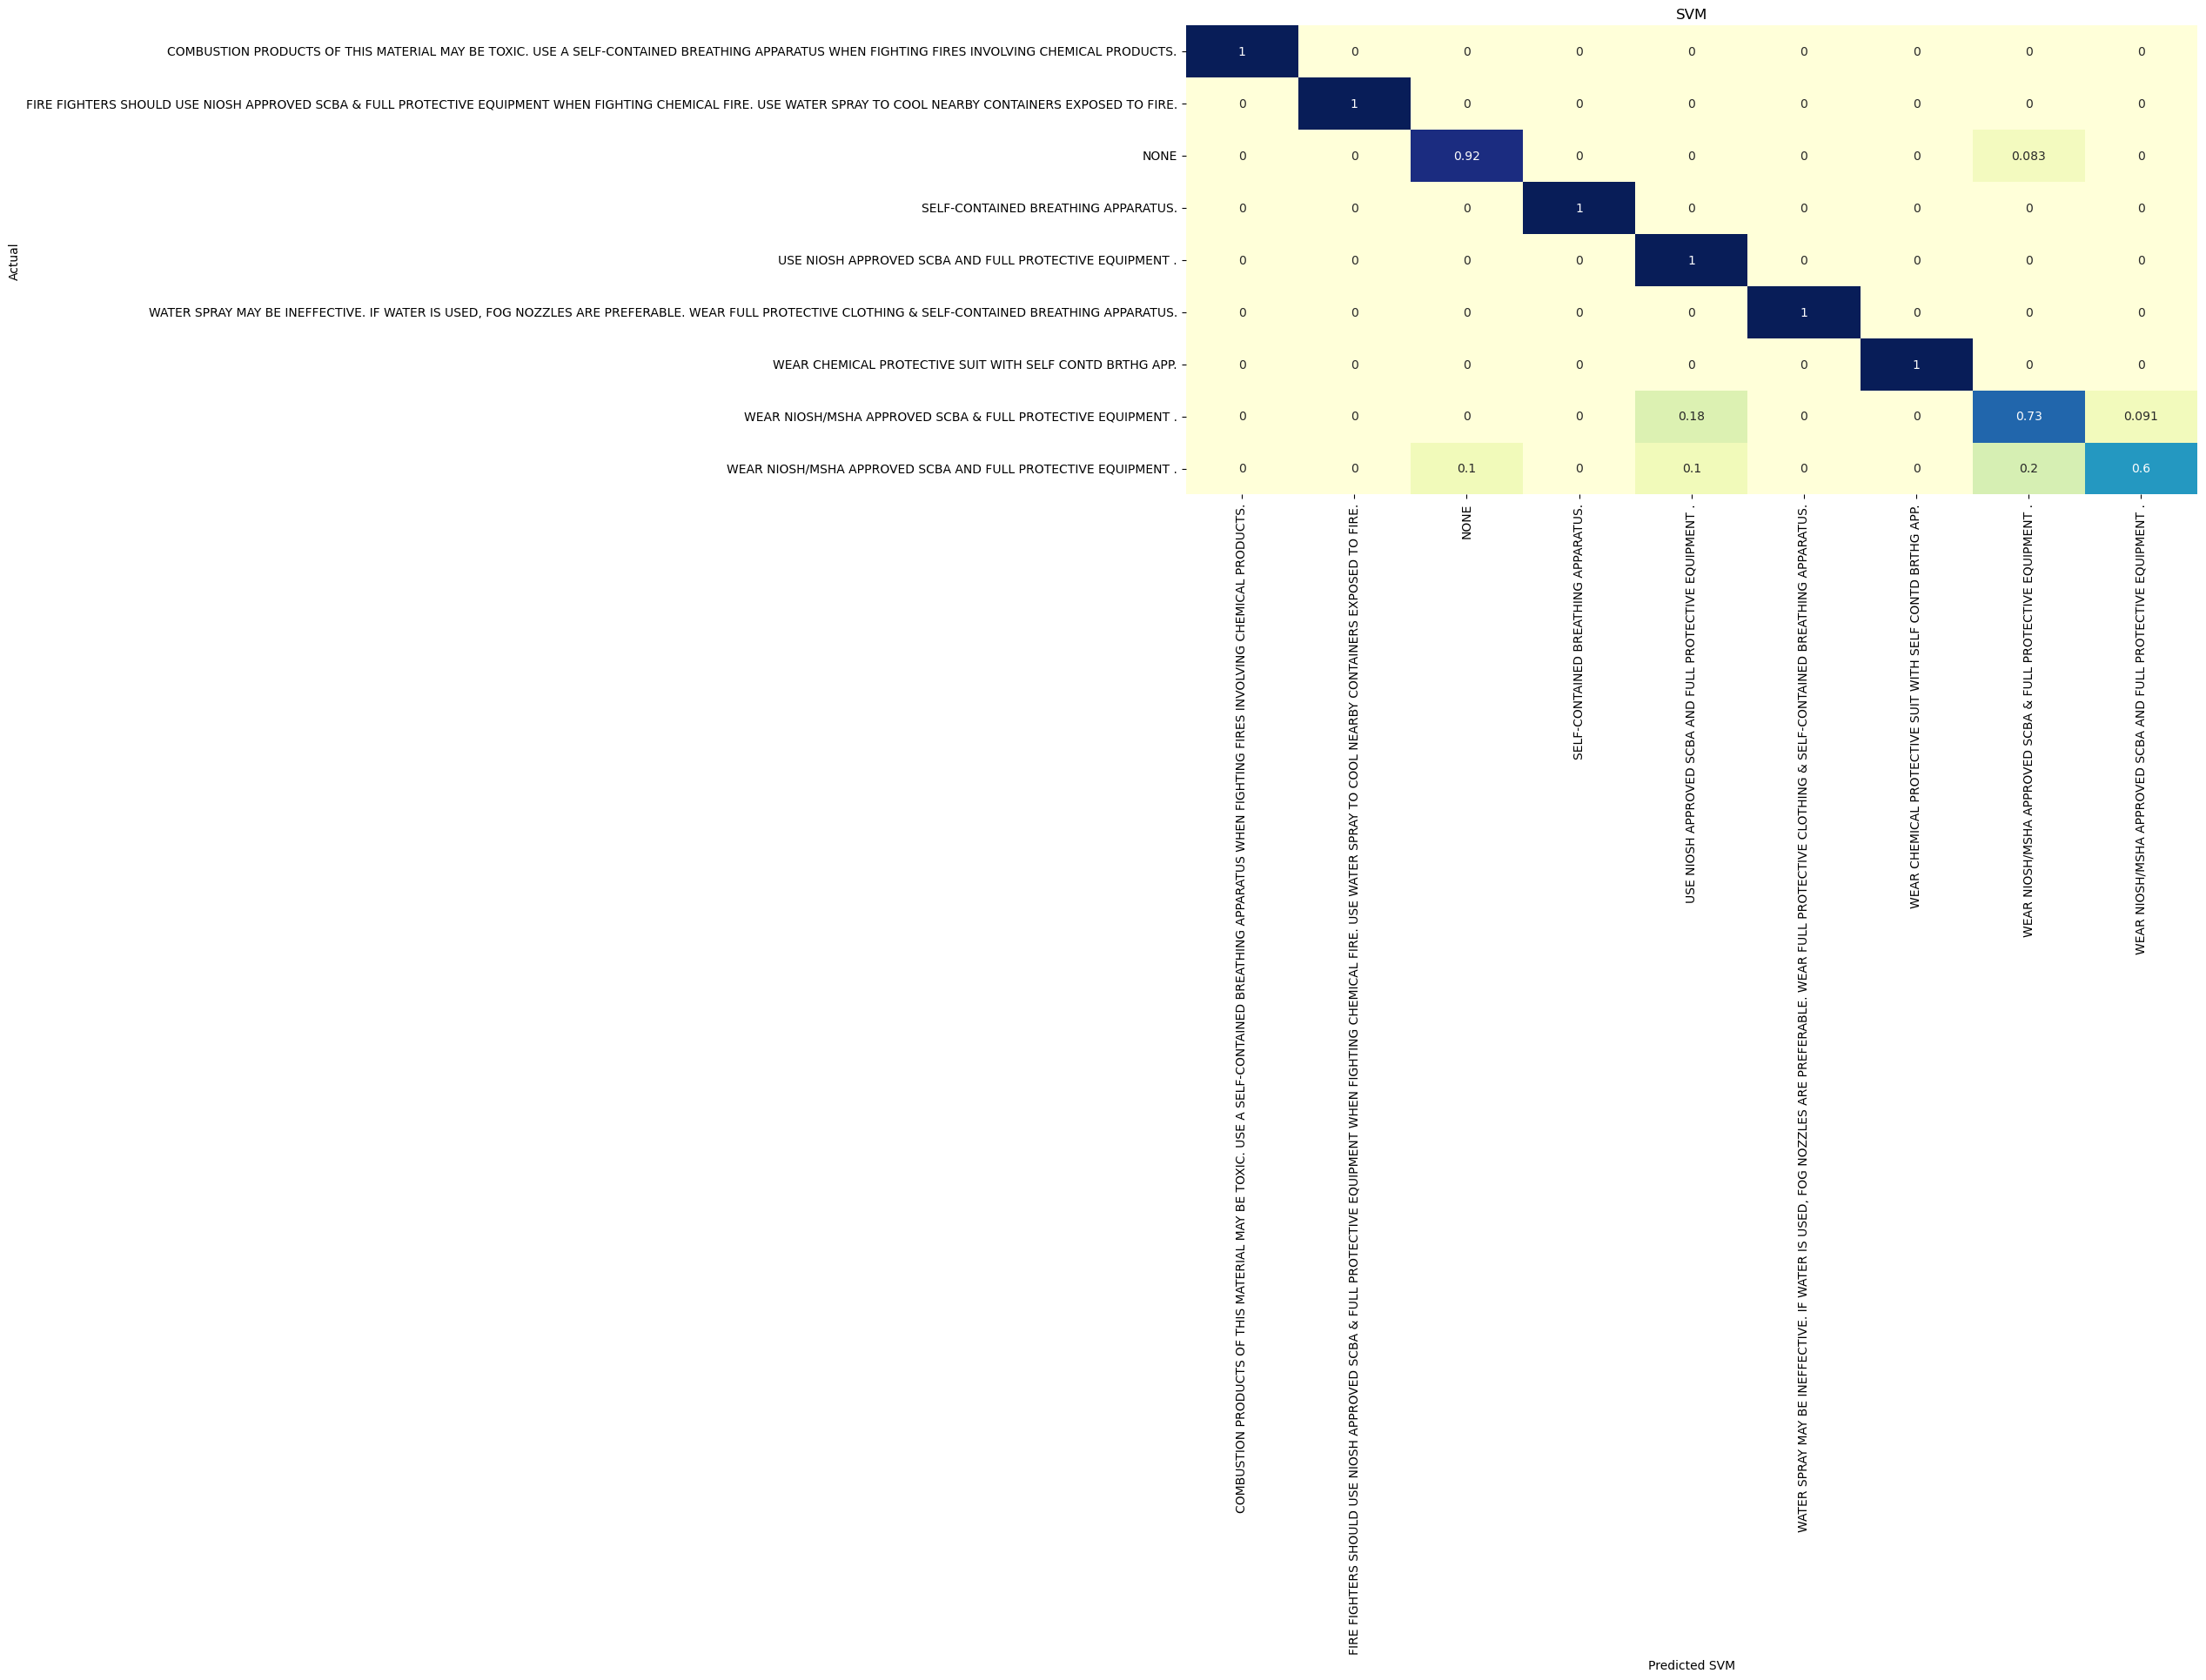

In [22]:
create_plot(result_df)

Example prediction:

In [23]:
tfidf_classification_model.run('DEPENDS ON CHEMICAL COMPOSITION; FISSION PRODUCTS SAFETY GLASSES EYE WASH STATION. APRONS. SPECIAL IMPERVIOUS CLOTHING. IMPERVIOUS SCBA IF INVOLVED IN FIRE, OTHERWISE GAS MASK. PROVIDE MECHAN(GEN/LOCAL EXHAUST)VENT TO MAINTN <TLV	')

{
  "classes": [
    {
      "class_name": "WEAR CHEMICAL PROTECTIVE SUIT WITH SELF CONTD BRTHG APP.",
      "confidence": 0.9841117454887399
    },
    {
      "class_name": "WEAR NIOSH/MSHA APPROVED SCBA AND FULL PROTECTIVE EQUIPMENT .",
      "confidence": 0.011109874866925499
    },
    {
      "class_name": "NONE",
      "confidence": 0.00964848893383156
    },
    {
      "class_name": "WEAR NIOSH/MSHA APPROVED SCBA & FULL PROTECTIVE EQUIPMENT .",
      "confidence": 0.0074855167074489234
    },
    {
      "class_name": "FIRE FIGHTERS SHOULD USE NIOSH APPROVED SCBA & FULL PROTECTIVE EQUIPMENT WHEN FIGHTING CHEMICAL FIRE. USE WATER SPRAY TO COOL NEARBY CONTAINERS EXPOSED TO FIRE.",
      "confidence": 0.005615642156923434
    },
    {
      "class_name": "SELF-CONTAINED BREATHING APPARATUS.",
      "confidence": 0.0038994128600961177
    },
    {
      "class_name": "COMBUSTION PRODUCTS OF THIS MATERIAL MAY BE TOXIC. USE A SELF-CONTAINED BREATHING APPARATUS WHEN FIGHTING FIRES IN

<a id="save_model"></a>
### Step 6: Save the classification model

You can save a model as a project asset. A ZIP archive can be created with `model.as_file_like_object()`, which is stored as a `BytesIO` object in the project.

In [24]:
from project_lib import Project

project.save_data('msds_classification_model', data=tfidf_classification_model.as_file_like_object(), overwrite=True)

{'file_name': 'msds_classification_model',
 'message': 'File saved to project storage.',
 'bucket_name': 'sapintegrationproject-donotdelete-pr-4qief86qjefdea',
 'asset_id': 'abc09ca1-db34-4f92-bb20-3aed9b979d9c'}

<a id="summary"></a>
## Summary

This notebook shows you how to use the Watson NLP library and how quickly and easily you can train and run different text classifiers by connecting it to the Datasphere using Watson NLP.